# Projeto ELT - Gastos dos deputados federais

In [1]:
import pandas as pd
import requests

url = "https://dadosabertos.camara.leg.br/api/v2/deputados?ordem=ASC&ordenarPor=nome"
resultado = requests.get(url)
deputados = pd.DataFrame(resultado.json()['dados'])
gastos = []
for id in deputados.id:
    url_despesa= "https://dadosabertos.camara.leg.br/api/v2/deputados/"+str(id)+"/despesas?ordem=ASC&ano=2022"
    resposta = requests.get(url_despesa)
    gasto = pd.DataFrame(resposta.json()['dados'])
    gasto['id'] = id
    gastos.append(gasto)

# TRANSFORMAÇÃO 

In [2]:
total = pd.concat(gastos)
del total['dataDocumento']
del total['numRessarcimento']
del total['urlDocumento']
total.nomeFornecedor = [str(fornecedor).upper().replace("S.A.", "S.A").replace("S/A", "S.A") for fornecedor in  total.nomeFornecedor]

# CARGA

In [3]:
from sqlalchemy import create_engine

In [4]:
engine = create_engine('sqlite:///dados_abertos.db')

In [5]:
deputados.to_sql('deputados', engine)

513

In [6]:
total.to_sql('despesas_total', engine)

4185

# ANÁLISE

In [9]:
total = pd.read_sql("select * from despesas_total;", engine)

In [11]:
deputados = pd.read_sql("select * from deputados", engine)

In [14]:
total = total.merge(deputados, on=['id'])

In [16]:
gastos_deputados = total.groupby(['nome']).sum()[['valorDocumento', 'valorLiquido']]

C:\Users\Gabriel Morisco\AppData\Local\Temp\ipykernel_14232\1638856533.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gastos_deputados = total.groupby(['nome']).sum()[['valorDocumento', 'valorLiquido']]


# DEPUTADOS COM MAIS GASTOS

In [20]:
gastos_deputados = gastos_deputados.sort_values('valorDocumento', ascending=False)
gastos_deputados.head(10)

,valorDocumento,valorLiquido
nome,,
Vicentinho Júnior,399742.93,399493.57
Gustinho Ribeiro,363013.48,362819.93
Júnior Mano,245000.00,242268.43
Silas Câmara,196867.29,196727.49
Delegado Éder Mauro,167232.45,167232.45
Pr. Marco Feliciano,149163.54,149163.54
Giacobo,144840.00,144840.00
Magda Mofatto,143224.52,143150.44
Vinicius Gurgel,140880.52,140880.52


# DEPUTADOS COM MENOS GASTOS

In [27]:
gastos_deputados.tail(10)

,valorDocumento,valorLiquido
nome,,
José Rocha,1737.92,1737.92
Nicoletti,1710.55,1710.46
Alceu Moreira,1673.77,1661.41
Marcel van Hattem,1634.46,1624.23
Marcos Aurélio Sampaio,1560.03,1558.50
Pedro Uczai,1302.90,1301.29
Sargento Fahur,1193.61,1055.71
Adriana Ventura,919.81,907.89
Miguel Lombardi,817.76,816.40


# PRINCIPAIS FORNECEDORES

In [28]:
%matplotlib inline

<Axes: >

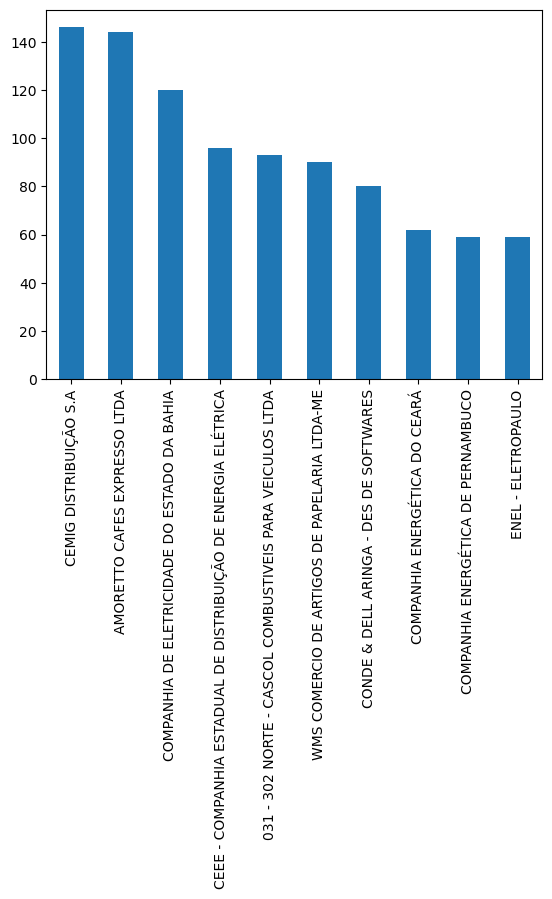

In [29]:
total.nomeFornecedor.value_counts()[:10].plot(kind="bar")